<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimizing-specific-fluxonium-property" data-toc-modified-id="Optimizing-specific-fluxonium-property-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimizing specific fluxonium property</a></span><ul class="toc-item"><li><span><a href="#Frequencies-and-matrix-elements-variation" data-toc-modified-id="Frequencies-and-matrix-elements-variation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Frequencies and matrix elements variation</a></span></li><li><span><a href="#Relaxation-time-at-sweet-spot" data-toc-modified-id="Relaxation-time-at-sweet-spot-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relaxation time at sweet spot</a></span></li><li><span><a href="#Frequency-fluctuation" data-toc-modified-id="Frequency-fluctuation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Frequency fluctuation</a></span></li><li><span><a href="#Wavefunctions" data-toc-modified-id="Wavefunctions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Wavefunctions</a></span></li></ul></li></ul></div>

# Optimizing specific fluxonium property


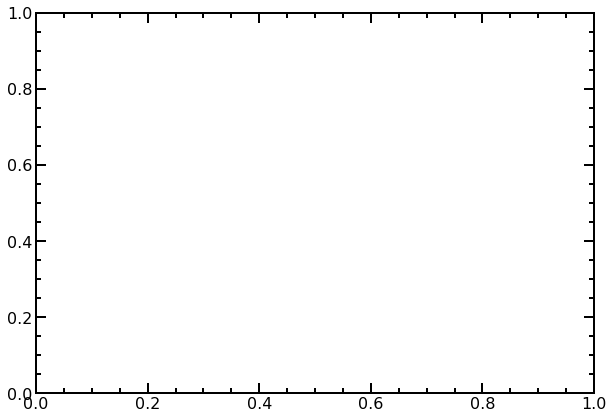

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
from scipy.optimize import minimize
from scipy.special import eval_hermite as hpoly
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

## Frequencies and matrix elements variation

In [7]:
N = 30 #number of levels
E_C = 1 #Charging energy, GHz
level_num = 10
phi_ext = 0.5

h = 6.626e-34 #Planck constant
kB = 1.38e-23 #Boltzmann constant

In [30]:
E_L = np.linspace (0.3,1.5,61)
E_J = np.linspace(2,6,201)
energies = np.zeros((len(E_J), len(E_L), 10))
n_me = np.zeros((len(E_J), len(E_L), 10))
for idx, E_J_temp in enumerate(E_J):
    for idy, E_L_temp in enumerate(E_L):
        H = fluxonium.bare_hamiltonian(N, E_L_temp, E_C, E_J_temp, phi_ext*2*np.pi)
        energies[idx, idy,:] = H.eigenenergies()[:10]
        n_me[idx, idy, 0] = fluxonium.charge_matrix_element(N, E_L_temp, E_C, E_J_temp, phi*2*np.pi, 0, 1)
        n_me[idx, idy, 1] = fluxonium.charge_matrix_element(N, E_L_temp, E_C, E_J_temp, phi*2*np.pi, 1, 2)

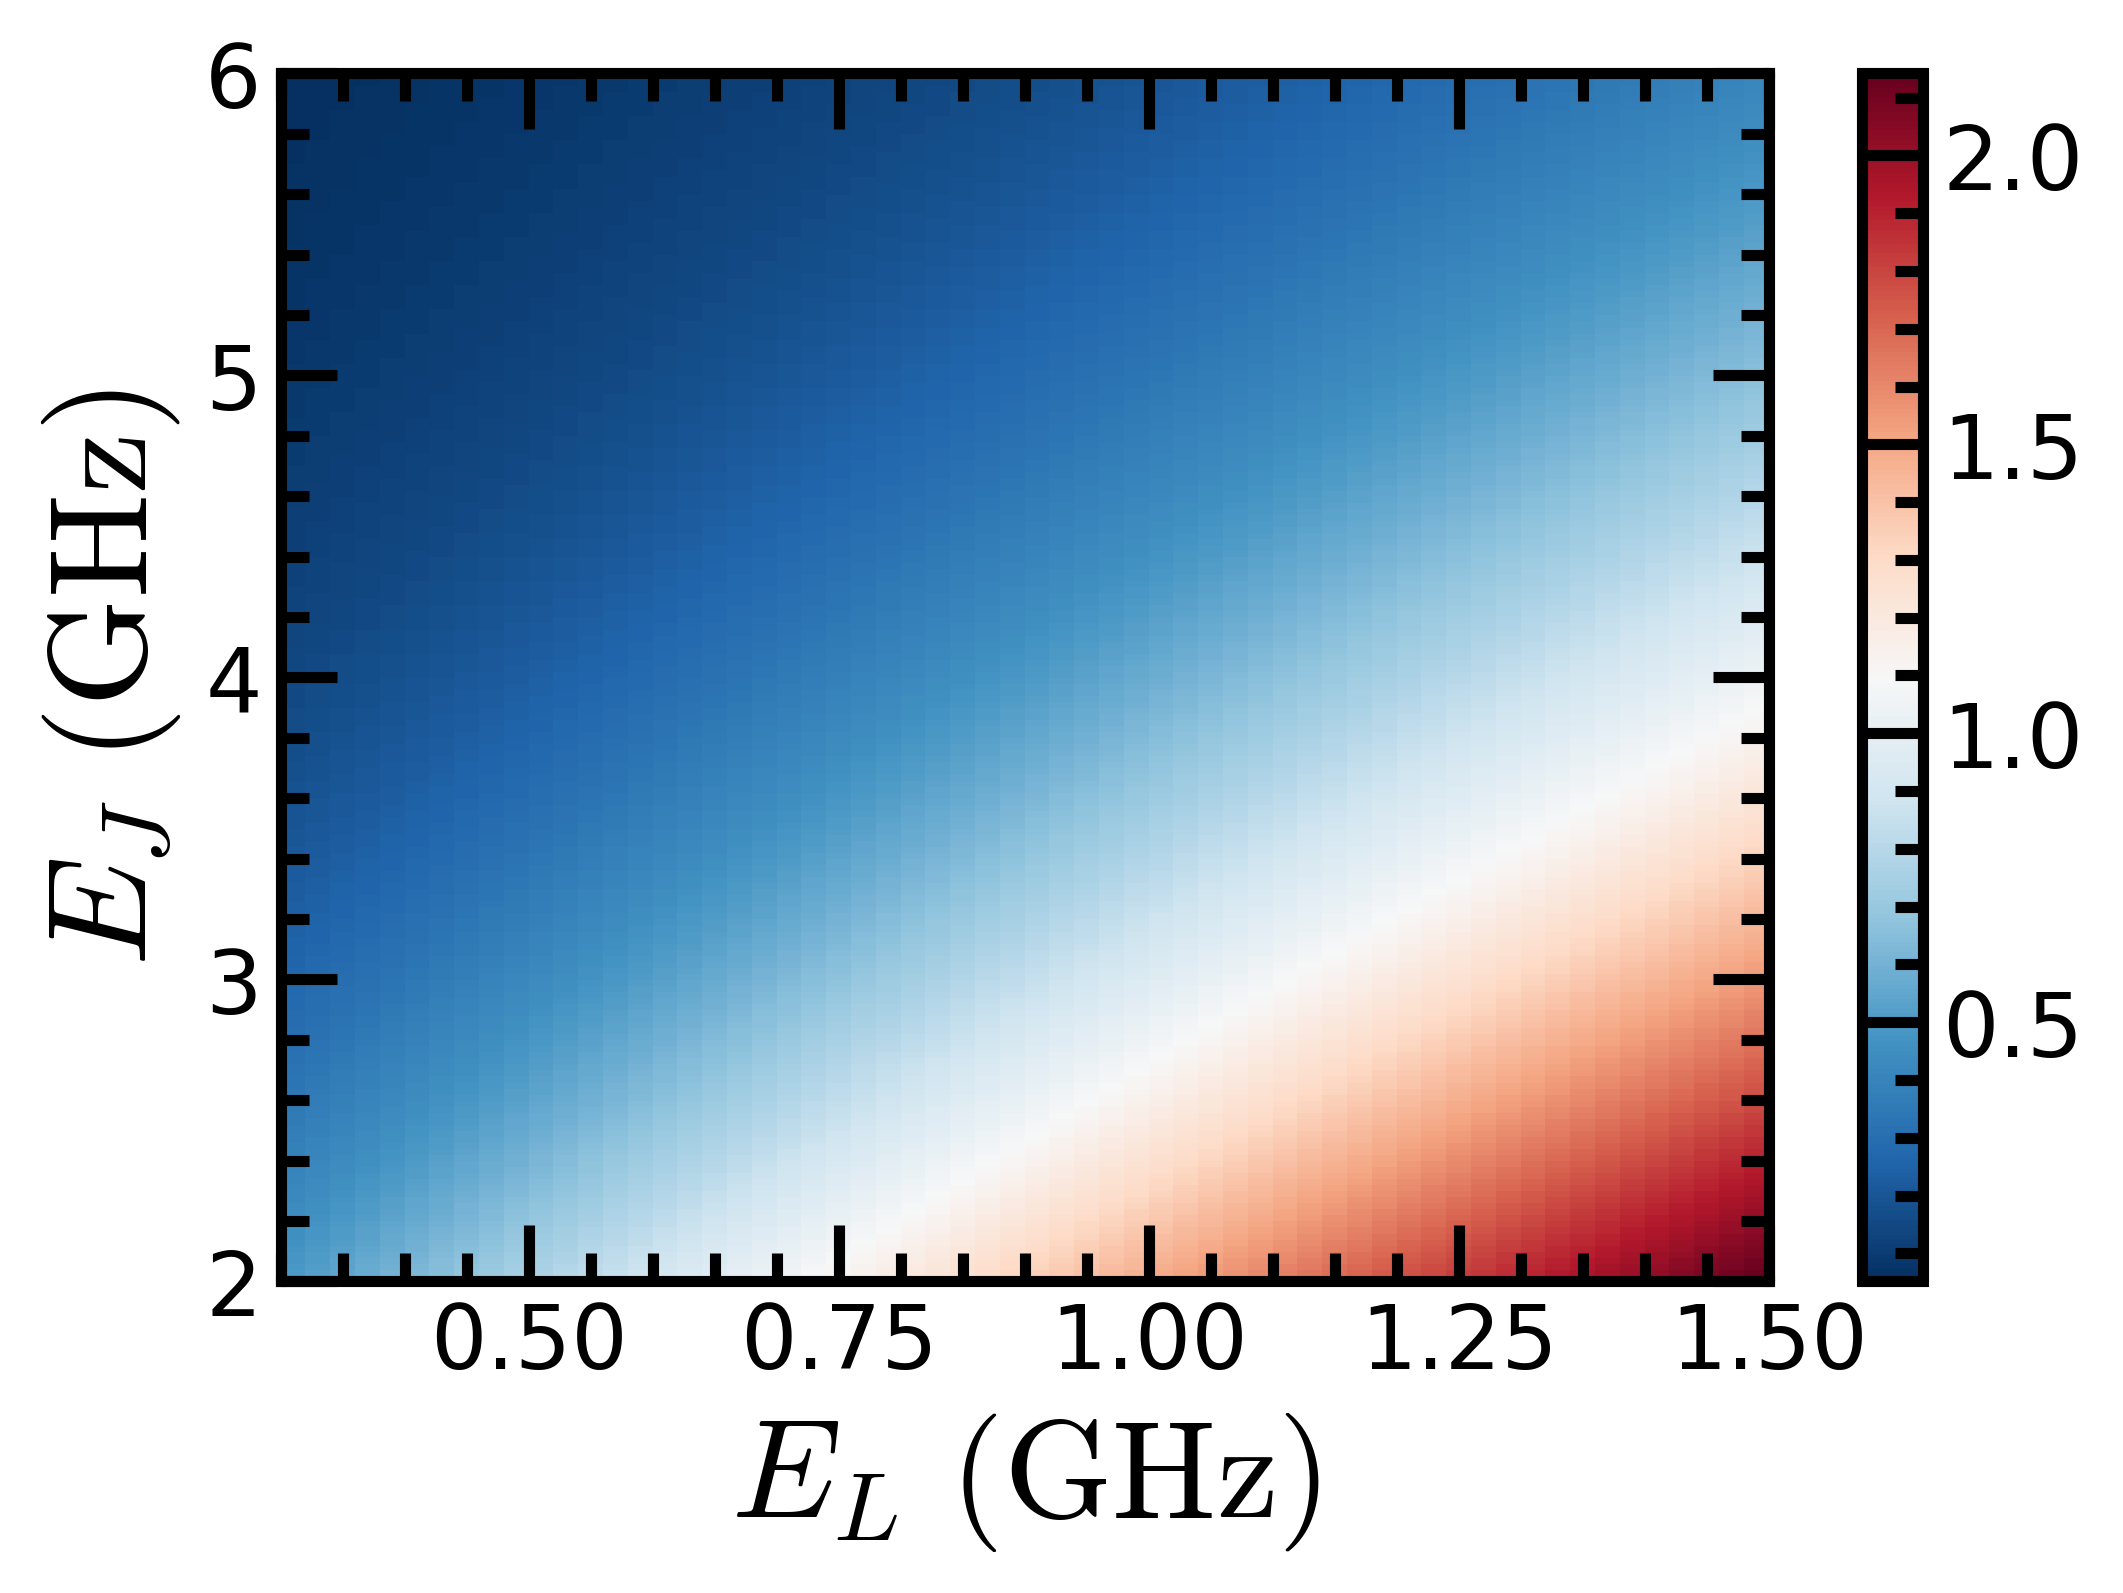

In [29]:
#Lowest energy
trans_01 = energies[:, :,1] - energies[:, :,0]
X,Y = np.meshgrid(E_L,E_J)
Z = trans_01
plt.pcolormesh(X,Y,Z, cmap = 'RdBu_r')#, vmin = 0.2, vmax = 1.5)
plt.ylabel(r'$E_J~(\mathrm{GHz})$')
plt.xlabel(r'$E_L~(\mathrm{GHz})$')
plt.colorbar()

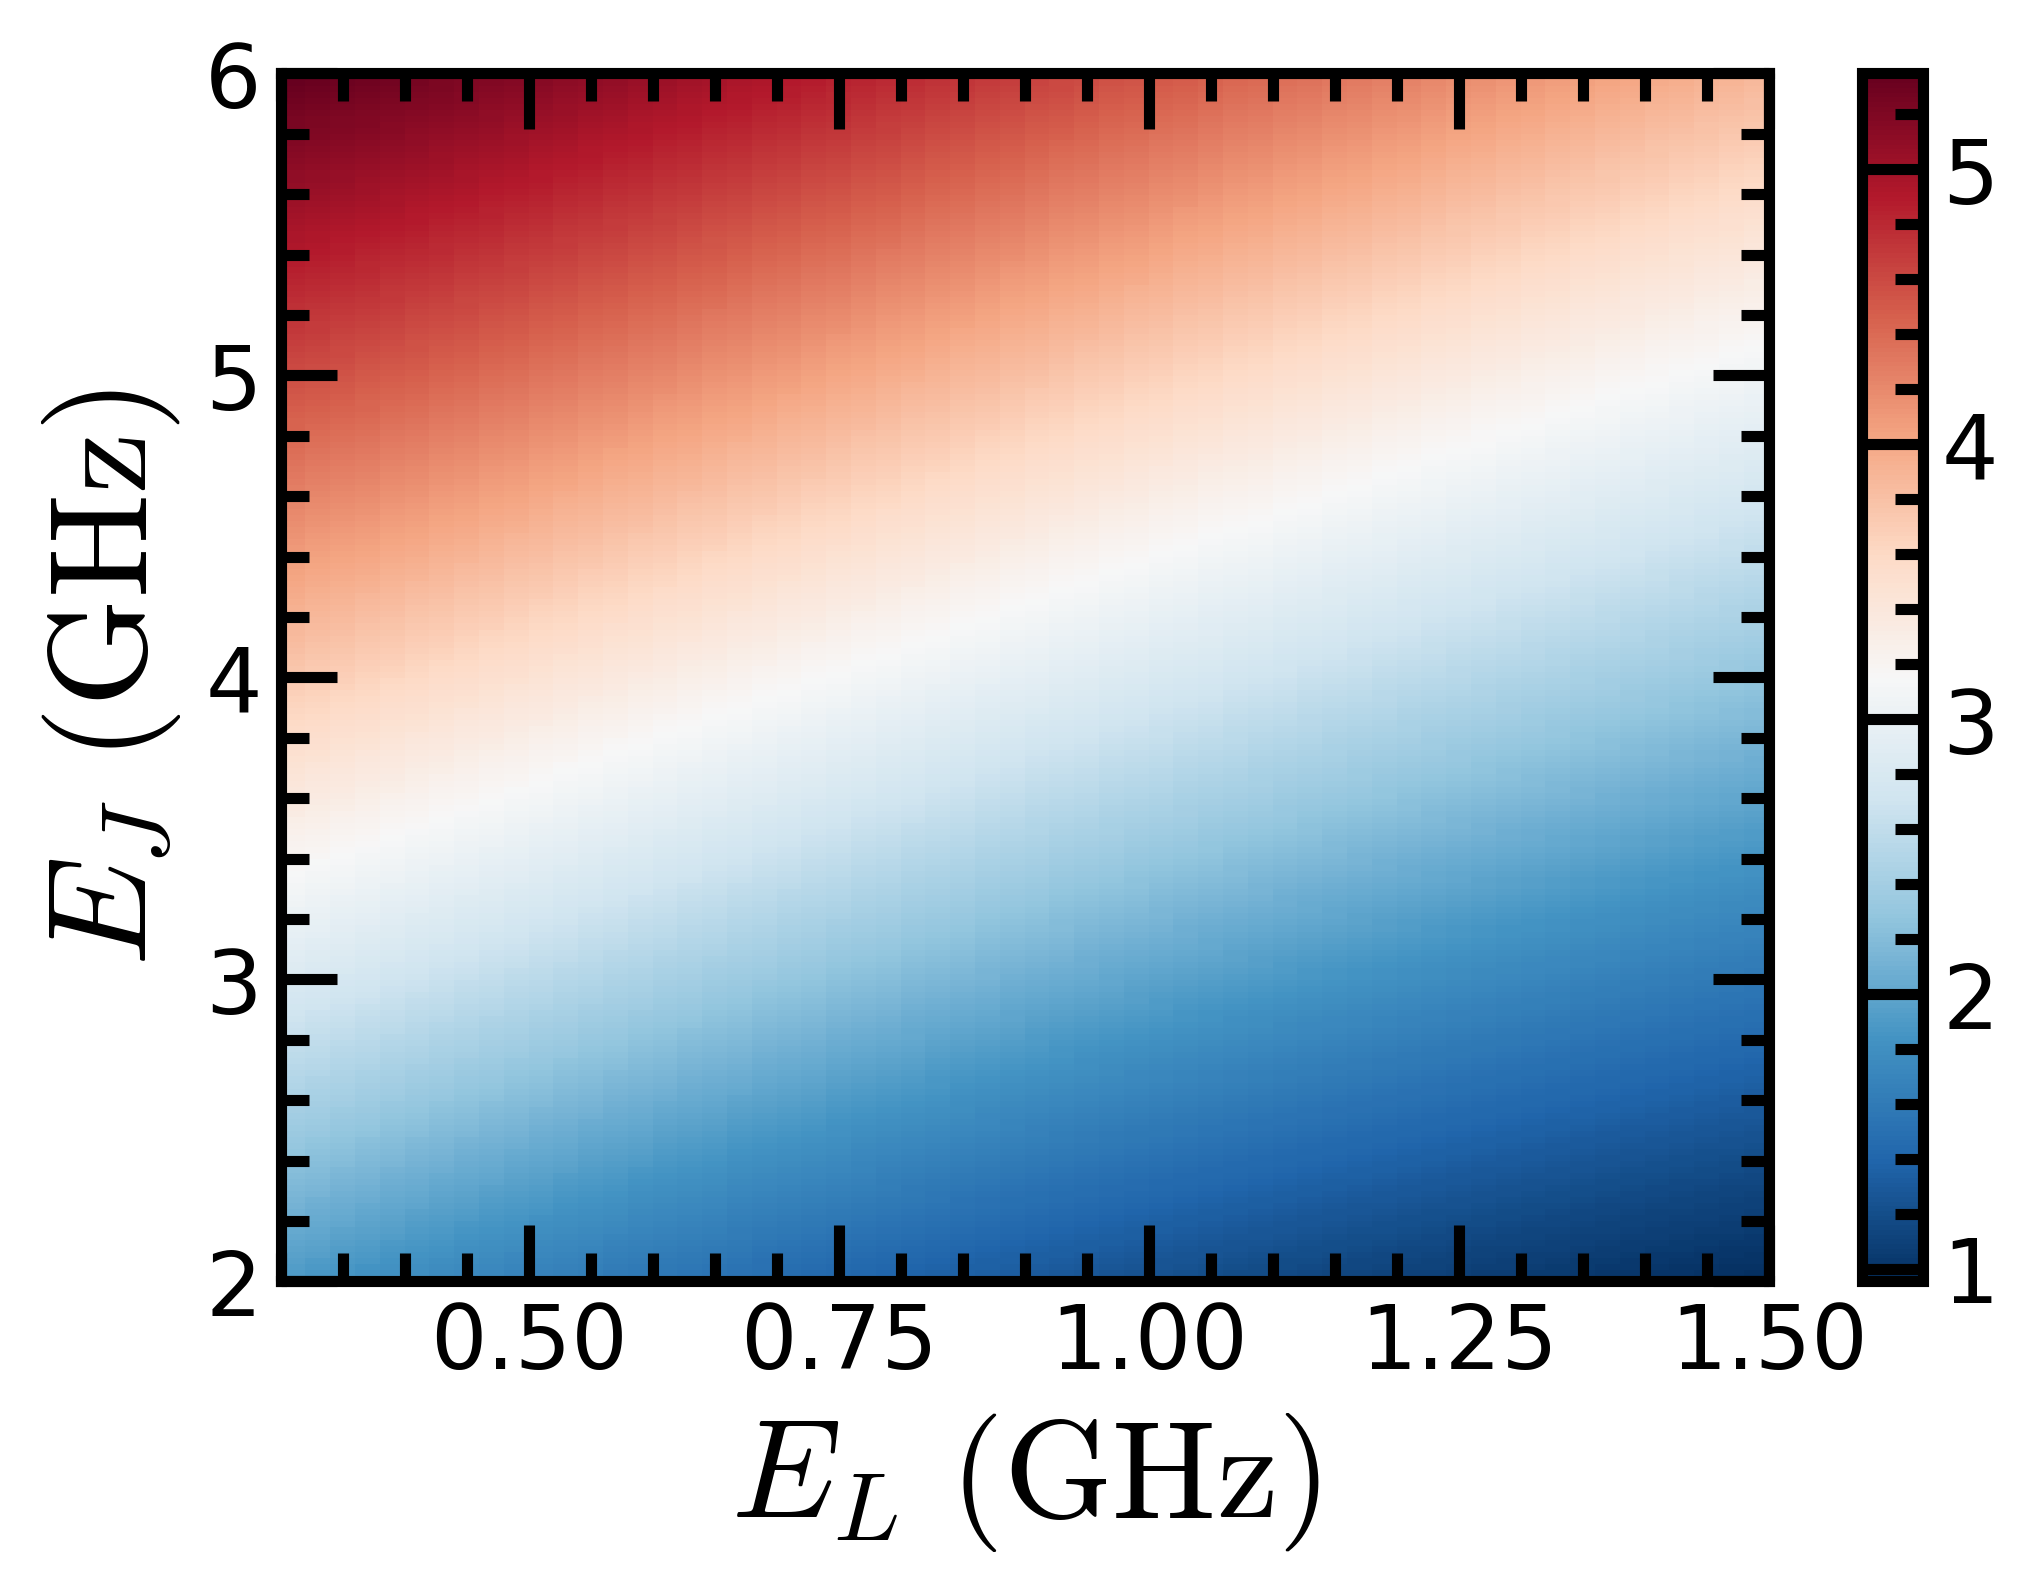

In [26]:
#anharmonicity
trans_12 = energies[:, :,2] - energies[:, :,1]
anhar = trans_12-trans_01
X,Y = np.meshgrid(E_L,E_J)
Z = anhar
plt.pcolormesh(X,Y,Z, cmap = 'RdBu_r')
plt.ylabel(r'$E_J~\mathrm{(GHz)}$')
plt.xlabel(r'$E_L~\mathrm{(GHz)}$')
plt.colorbar()

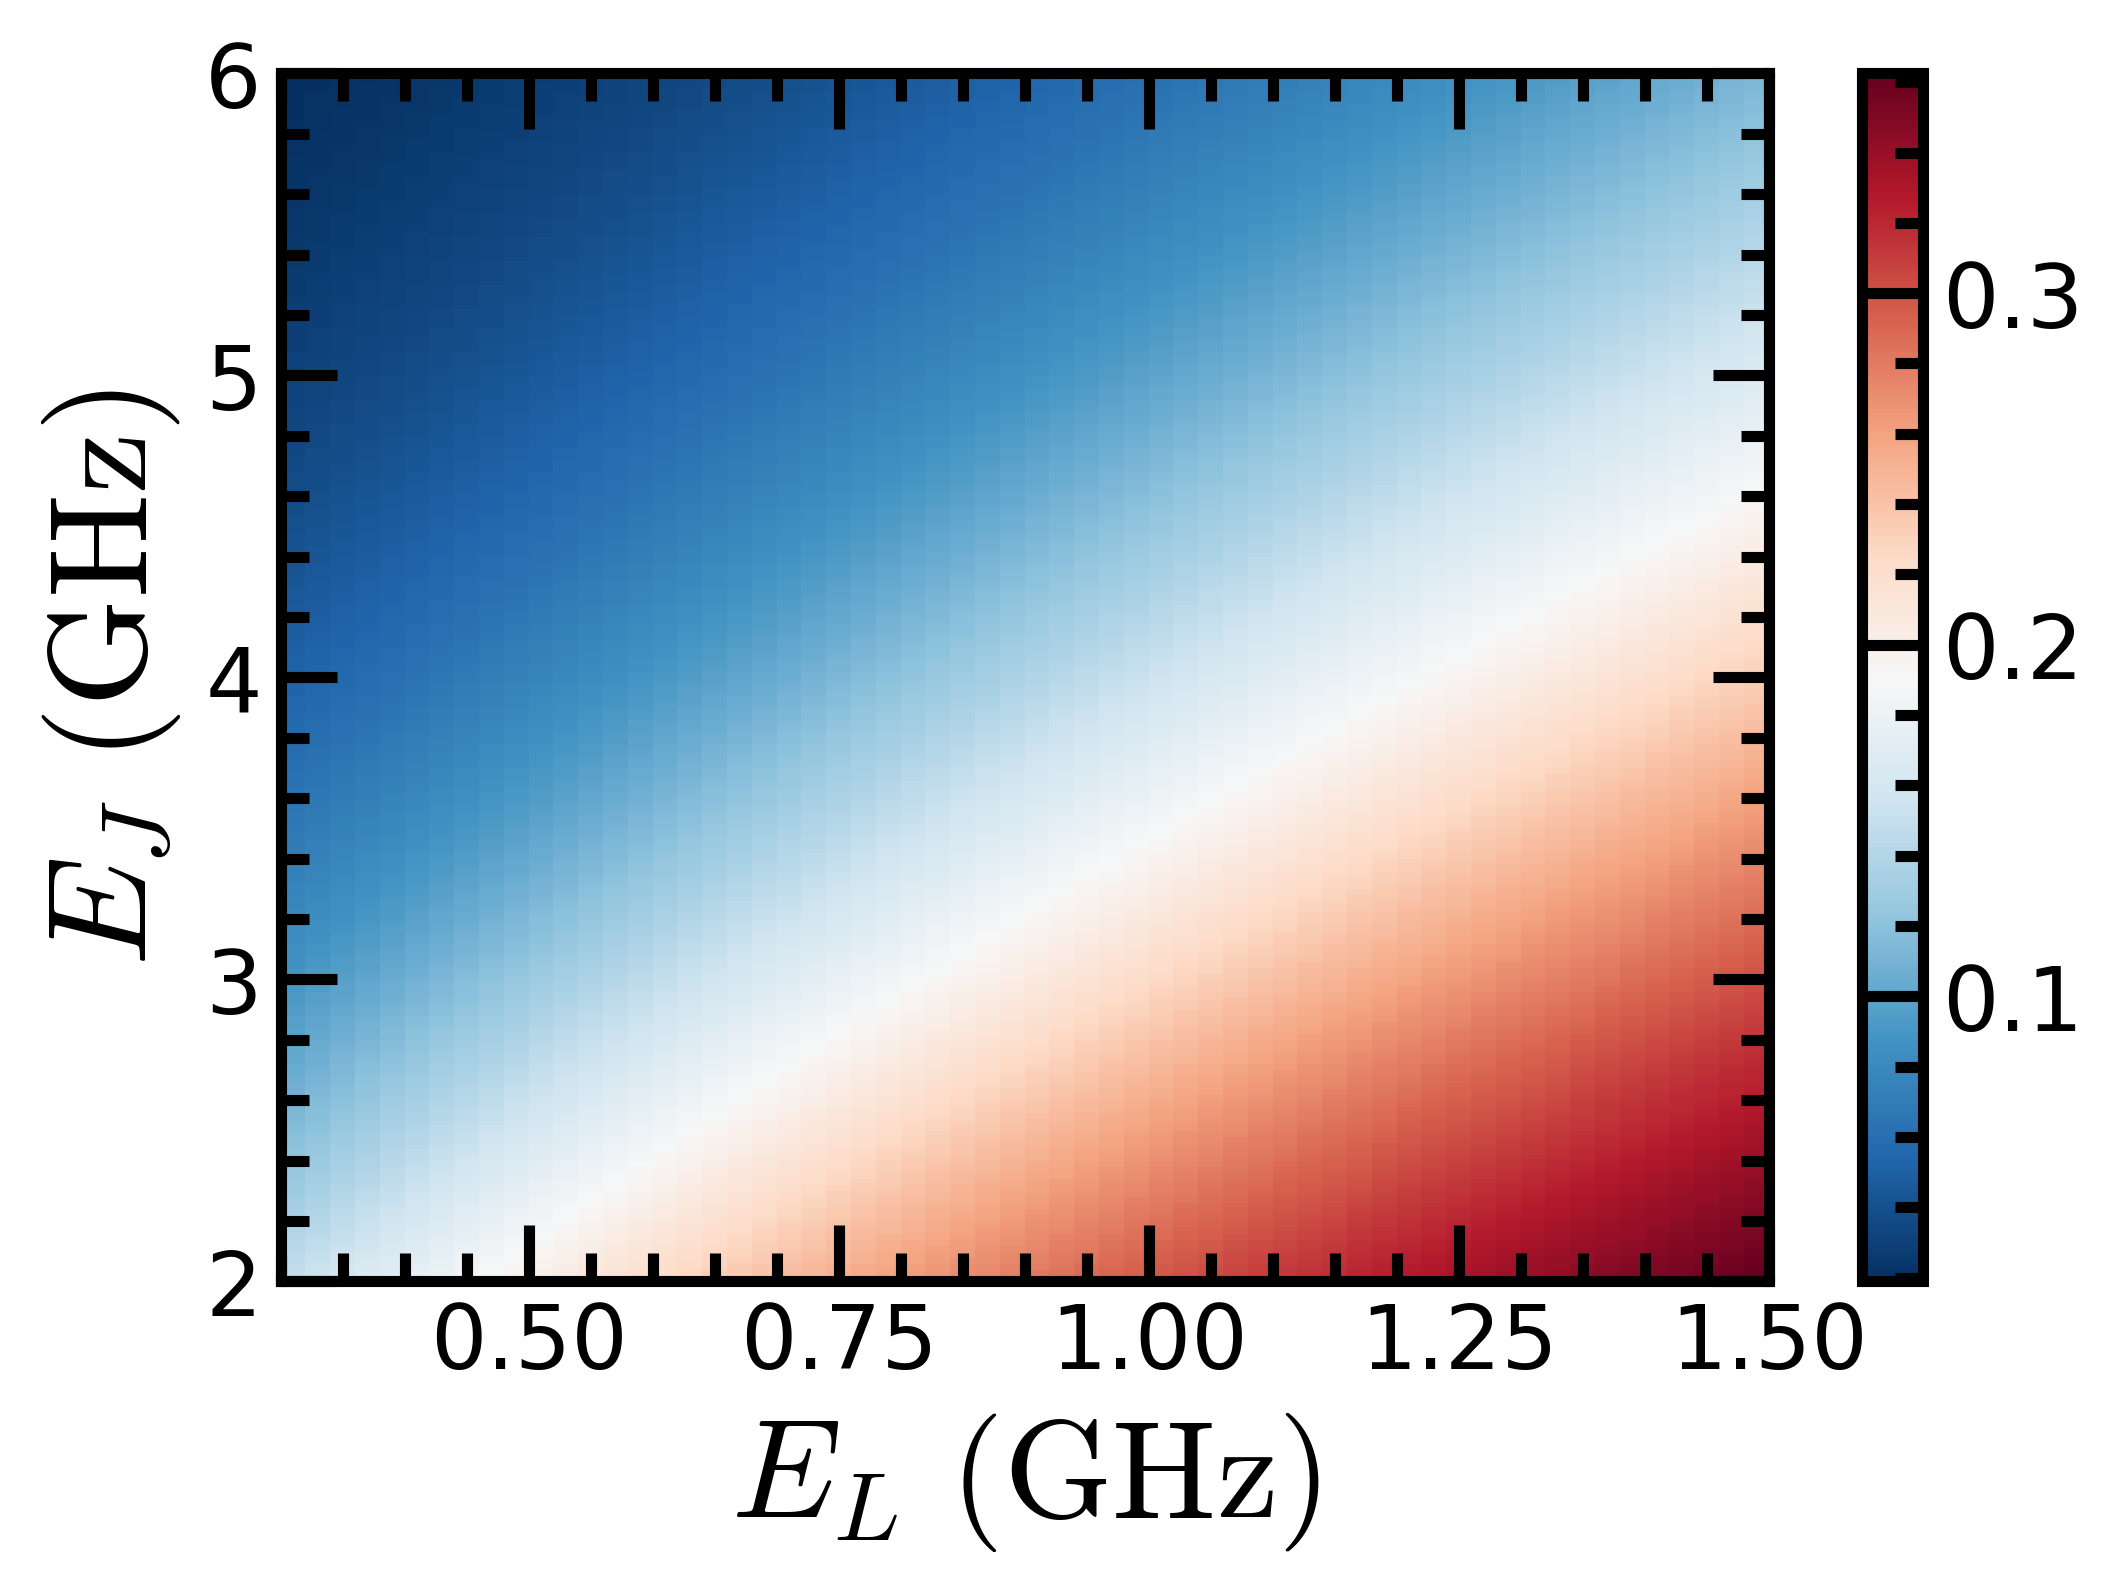

In [33]:
#01 matrix element
X,Y = np.meshgrid(E_L,E_J)
Z = n_me[:,:,0]
plt.pcolormesh(X,Y,Z, cmap = 'RdBu_r')
plt.ylabel(r'$E_J~\mathrm{(GHz)}$')
plt.xlabel(r'$E_L~\mathrm{(GHz)}$')
plt.colorbar()

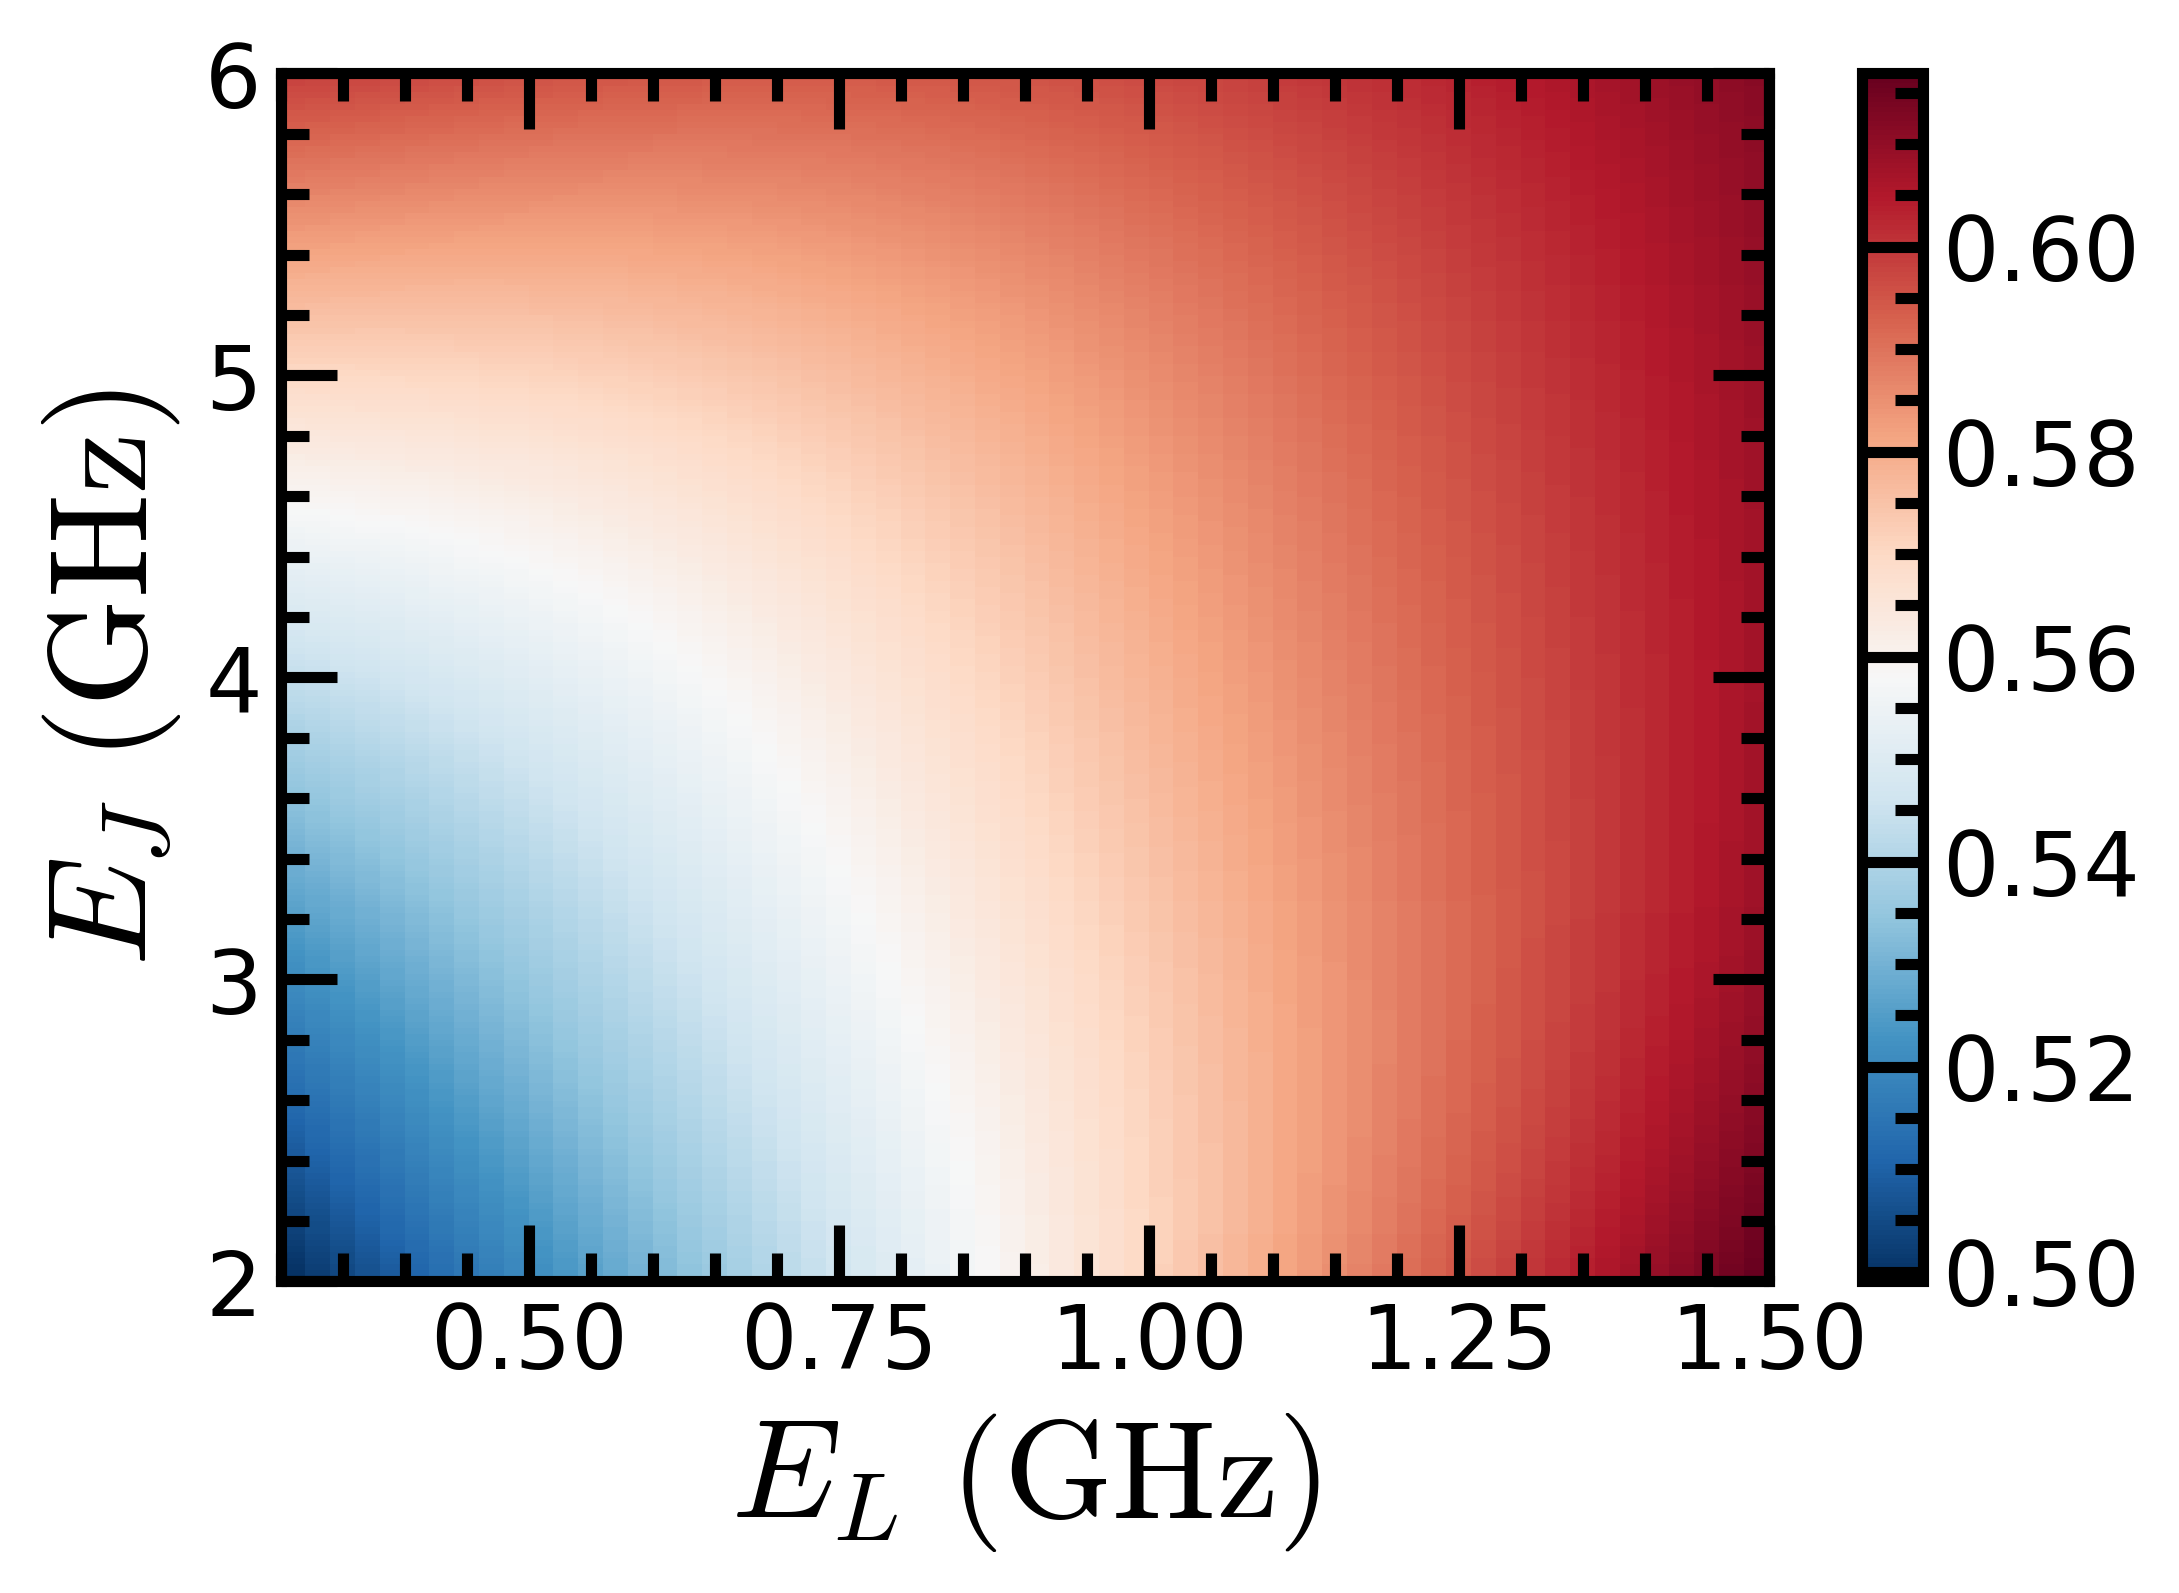

In [34]:
#12 matrix element
X,Y = np.meshgrid(E_L,E_J)
Z = n_me[:,:,1]
plt.pcolormesh(X,Y,Z, cmap = 'RdBu_r')
plt.ylabel(r'$E_J~\mathrm{(GHz)}$')
plt.xlabel(r'$E_L~\mathrm{(GHz)}$')
plt.colorbar()

## Relaxation time at sweet spot

In [9]:
T_diel = 20e-3 #effective temperature in K
T_qp = 20e-3 #effective temperature in K
Q_cap = 1e6
Q_qp = 1e8
phi = 0.5

In [10]:
def gamma1(x):
    E_L = x[0]
    E_J = x[1]
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi) #Hamiltonian
    freq = H.eigenenergies()[1] - H.eigenenergies()[0] #transition freq
    thermal_factor_diel = (1+np.exp(-h*freq*1e9/(kB*T_diel)))
    thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
    p_me = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1) #Matrix element
    gamma_cap = fluxonium.relaxation_rate_cap(E_L, E_C, E_J, Q_cap,freq, p_me, T_diel)*thermal_factor_diel
    gamma_qp = fluxonium.relaxation_rate_qp_array(E_L, E_C, E_J, Q_qp, freq, p_me)*thermal_factor_qp
    return abs(p_me)

In [11]:
# x0 = [1.0,4.0]
# opt = minimize(gamma1, x0, method='Powell', tol = 1e-1)
# print (opt)

In [12]:
E_L_array = np.linspace(0.2,2,181)
E_J_array = np.linspace(0.2,10,161)
gamma = np.zeros((len(E_J_array), len(E_L_array), 2), dtype = complex)
def gamma1(E_L, E_J):
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi) #Hamiltonian
    freq = H.eigenenergies()[1] - H.eigenenergies()[0] #transition freq
    thermal_factor_diel = (1+np.exp(-h*freq*1e9/(kB*T_diel)))
    thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
    p_me = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1) #Matrix element
    gamma_cap = fluxonium.relaxation_rate_cap(E_L, E_C, E_J, Q_cap,freq, p_me, T_diel)*thermal_factor_diel
    gamma_qp = fluxonium.relaxation_rate_qp_array(E_L, E_C, E_J, Q_qp, freq, p_me)*thermal_factor_qp
    return gamma_cap, gamma_qp

for J_idx, E_J in enumerate(E_J_array):
    for L_idx, E_L in enumerate(E_L_array):
        gamma[J_idx, L_idx, :] = gamma1(E_L, E_J)

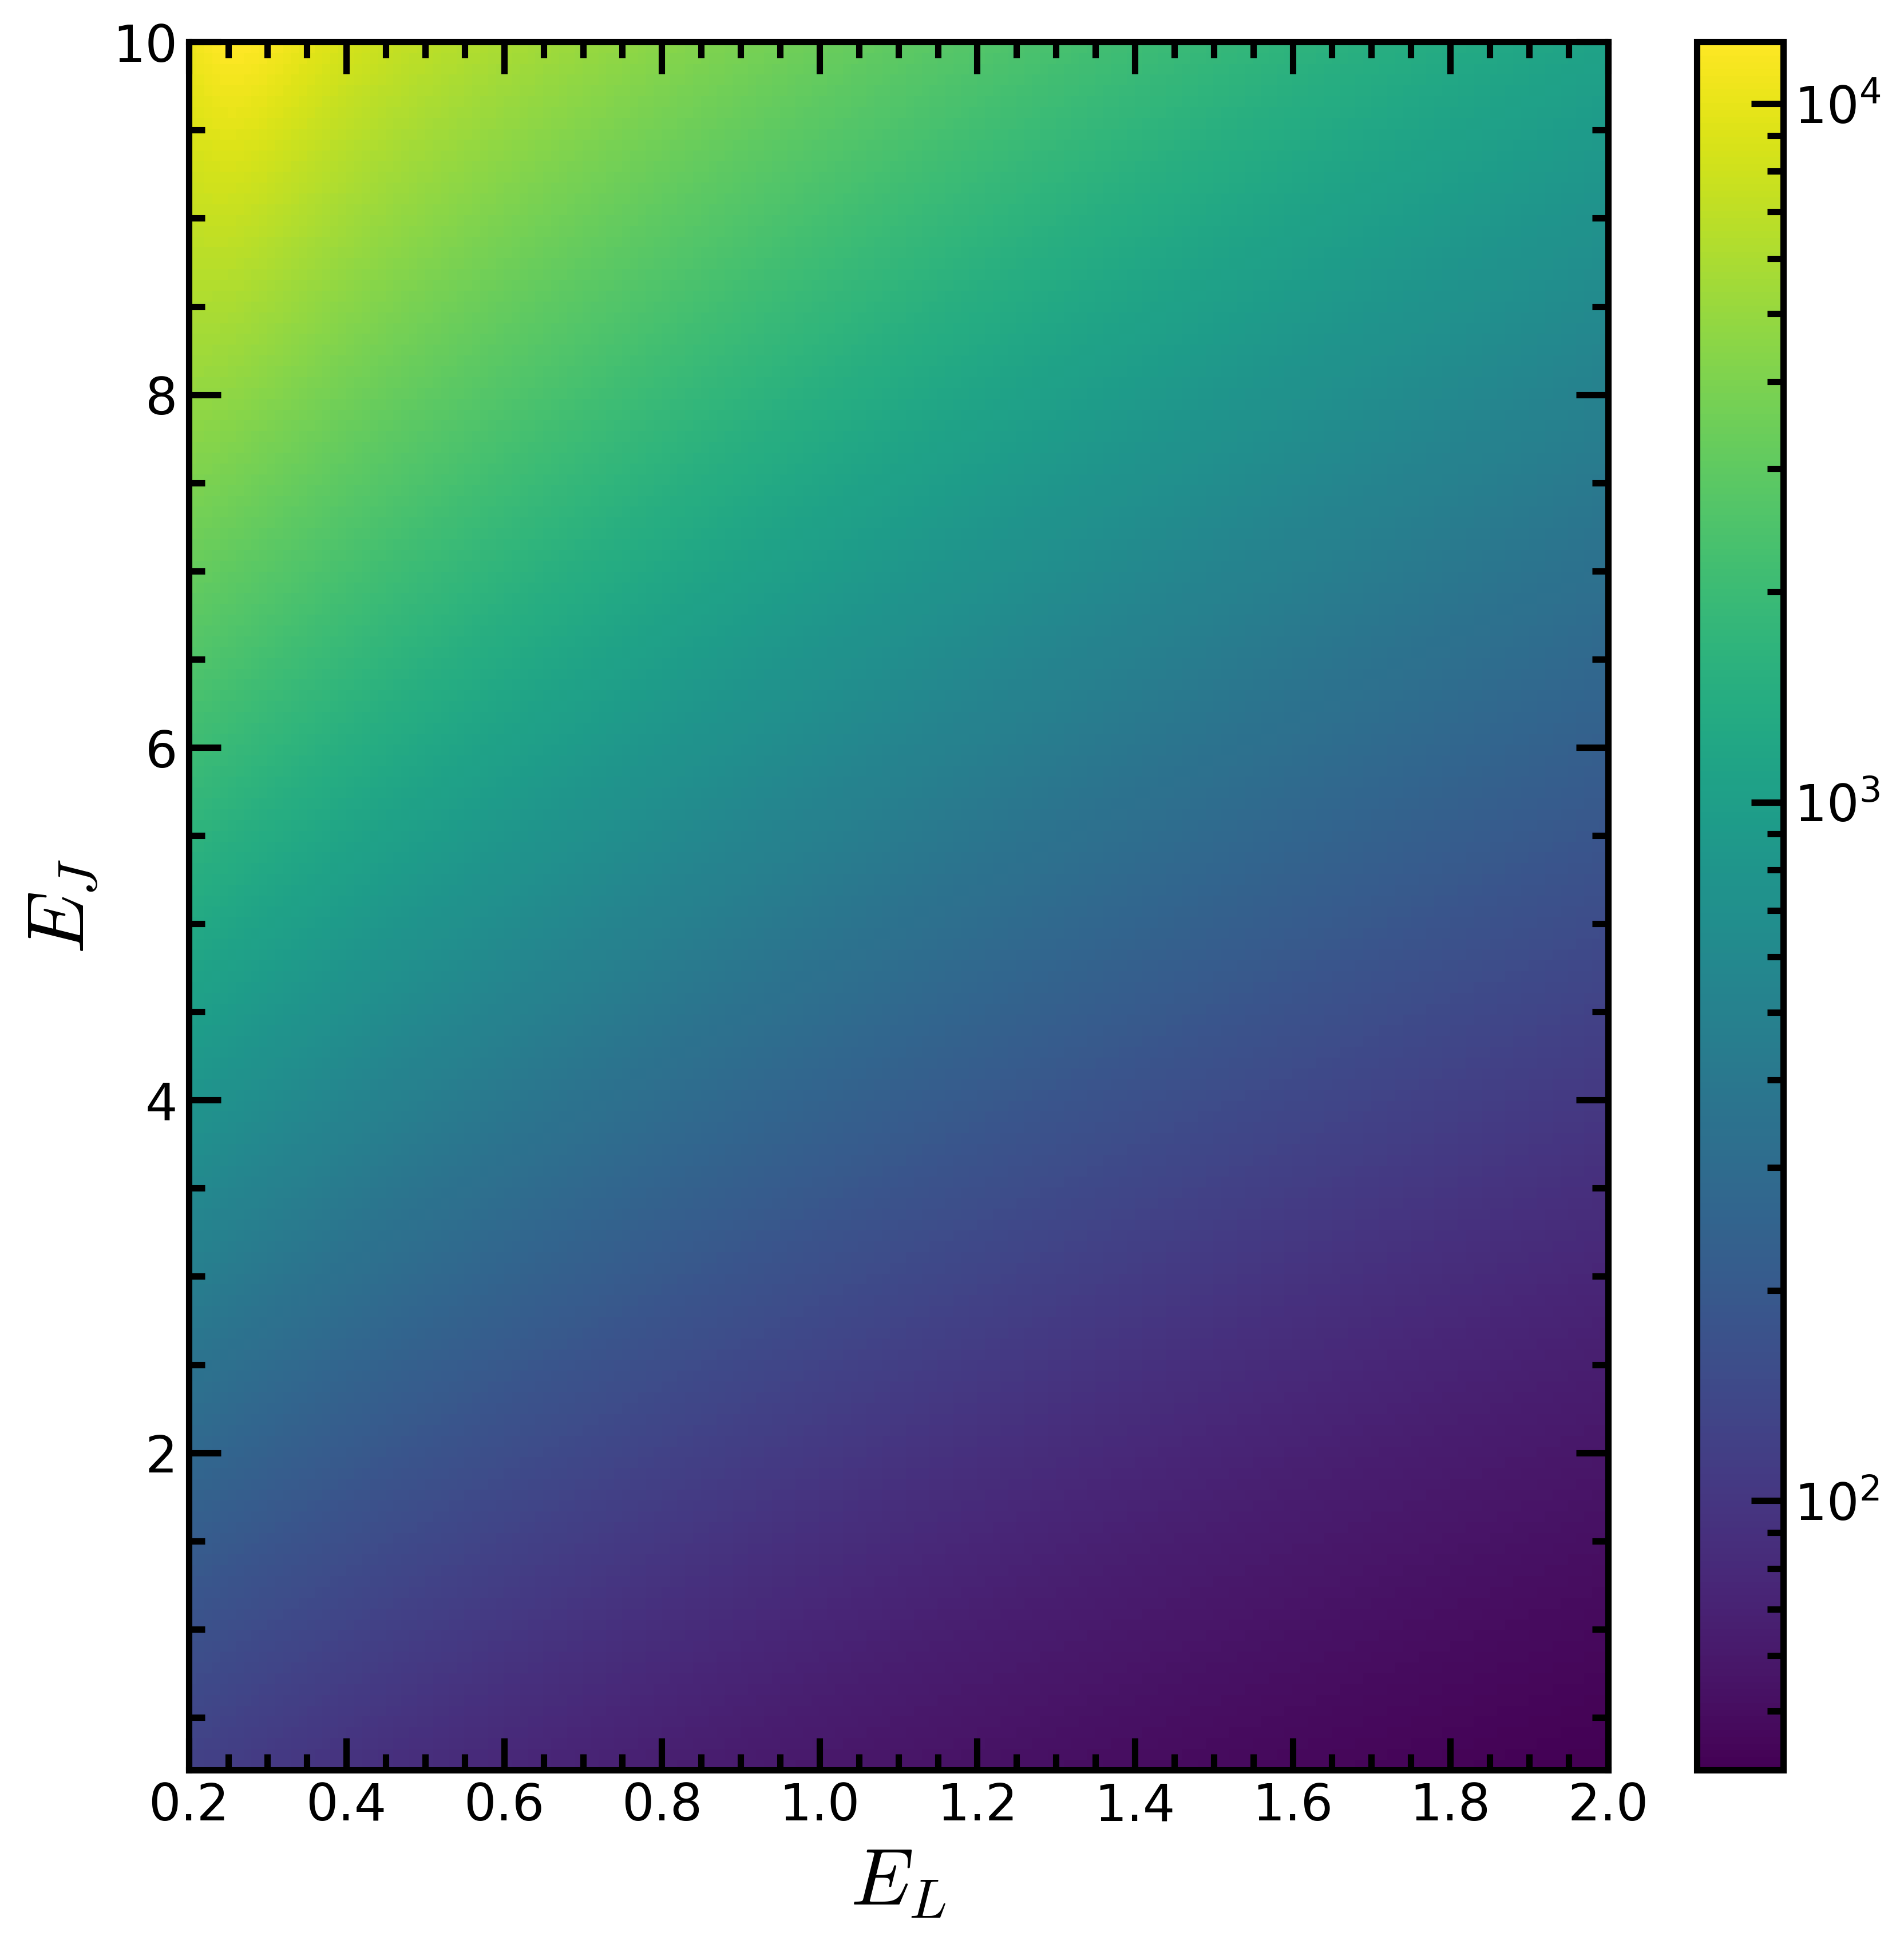

In [13]:
plt.figure(figsize=[10,10])
import matplotlib.colors as cl
plt.xlabel(r'$E_L$')
plt.ylabel(r'$E_J$')
X,Y = np.meshgrid(E_L_array, E_J_array)
Z = abs(gamma[:,:,0])
plt.pcolormesh(X,Y,(Z**-1)*1e6,norm=cl.LogNorm())
plt.colorbar()

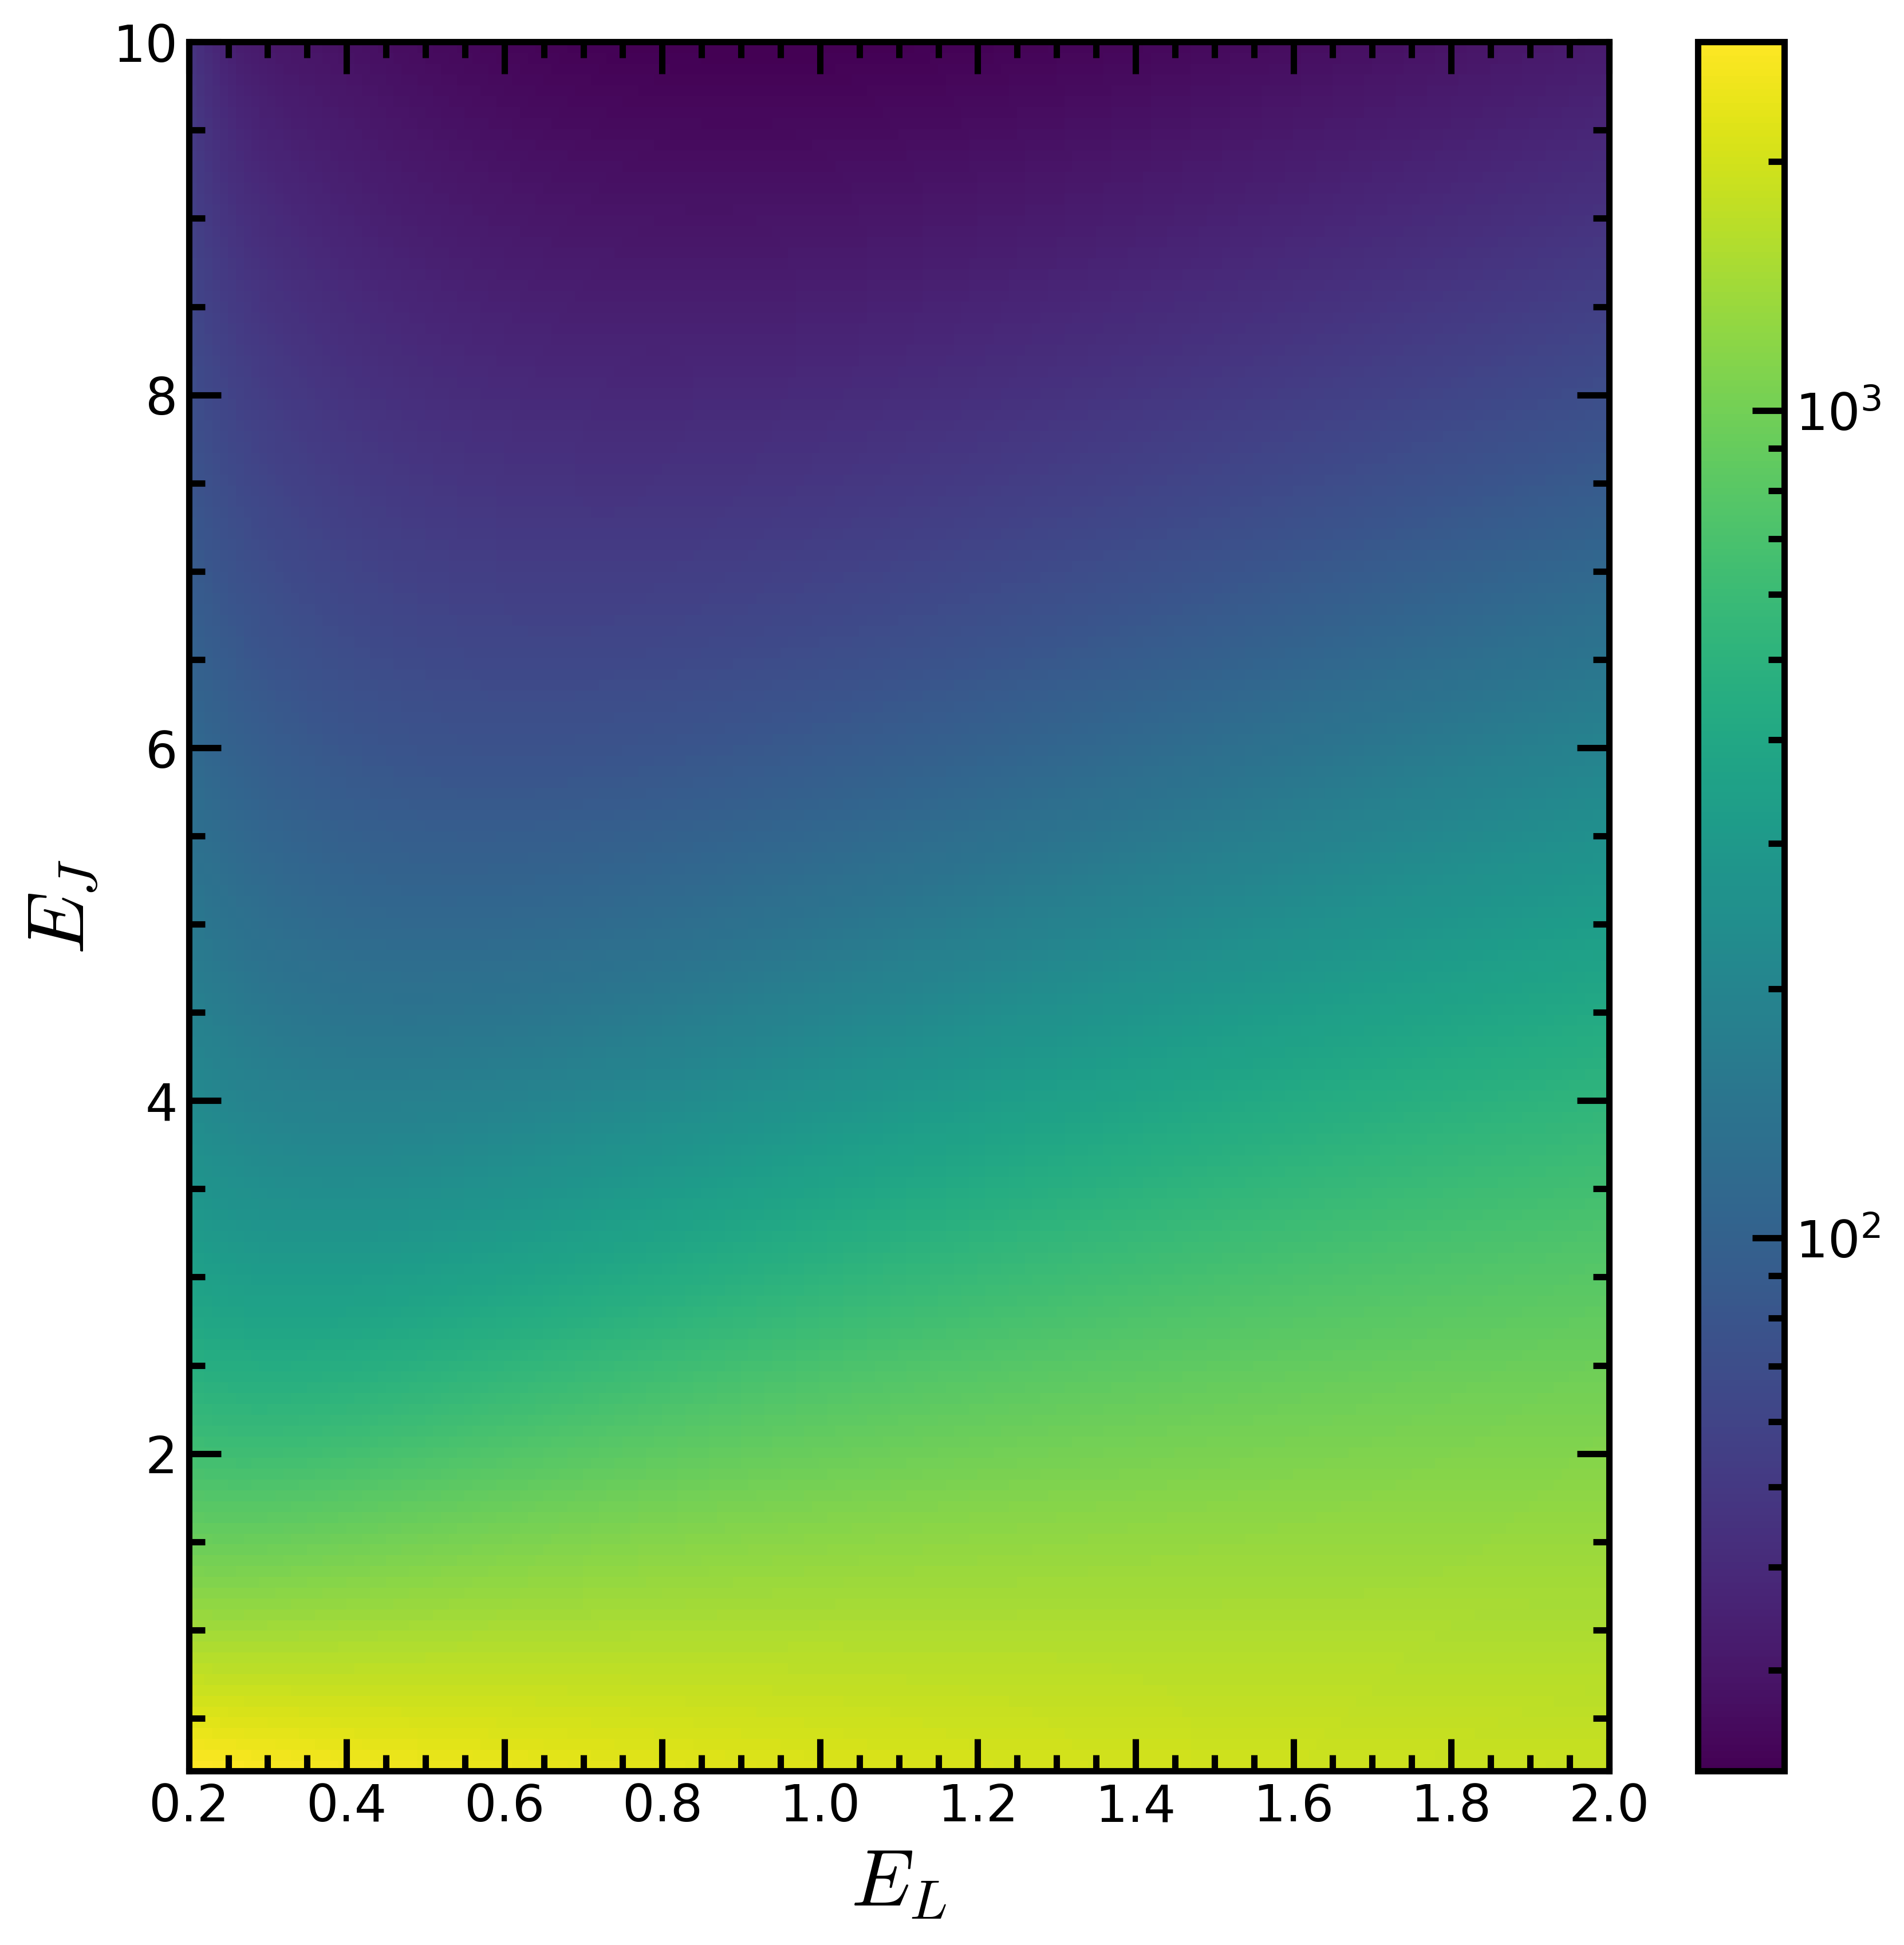

In [7]:
plt.figure(figsize=[10,10])
plt.xlabel(r'$E_L$')
plt.ylabel(r'$E_J$')
X,Y = np.meshgrid(E_L_array, E_J_array)
Z = abs(gamma[:,:,1])
plt.pcolormesh(X,Y,(Z**-1)*1e6,norm=cl.LogNorm())
plt.colorbar()

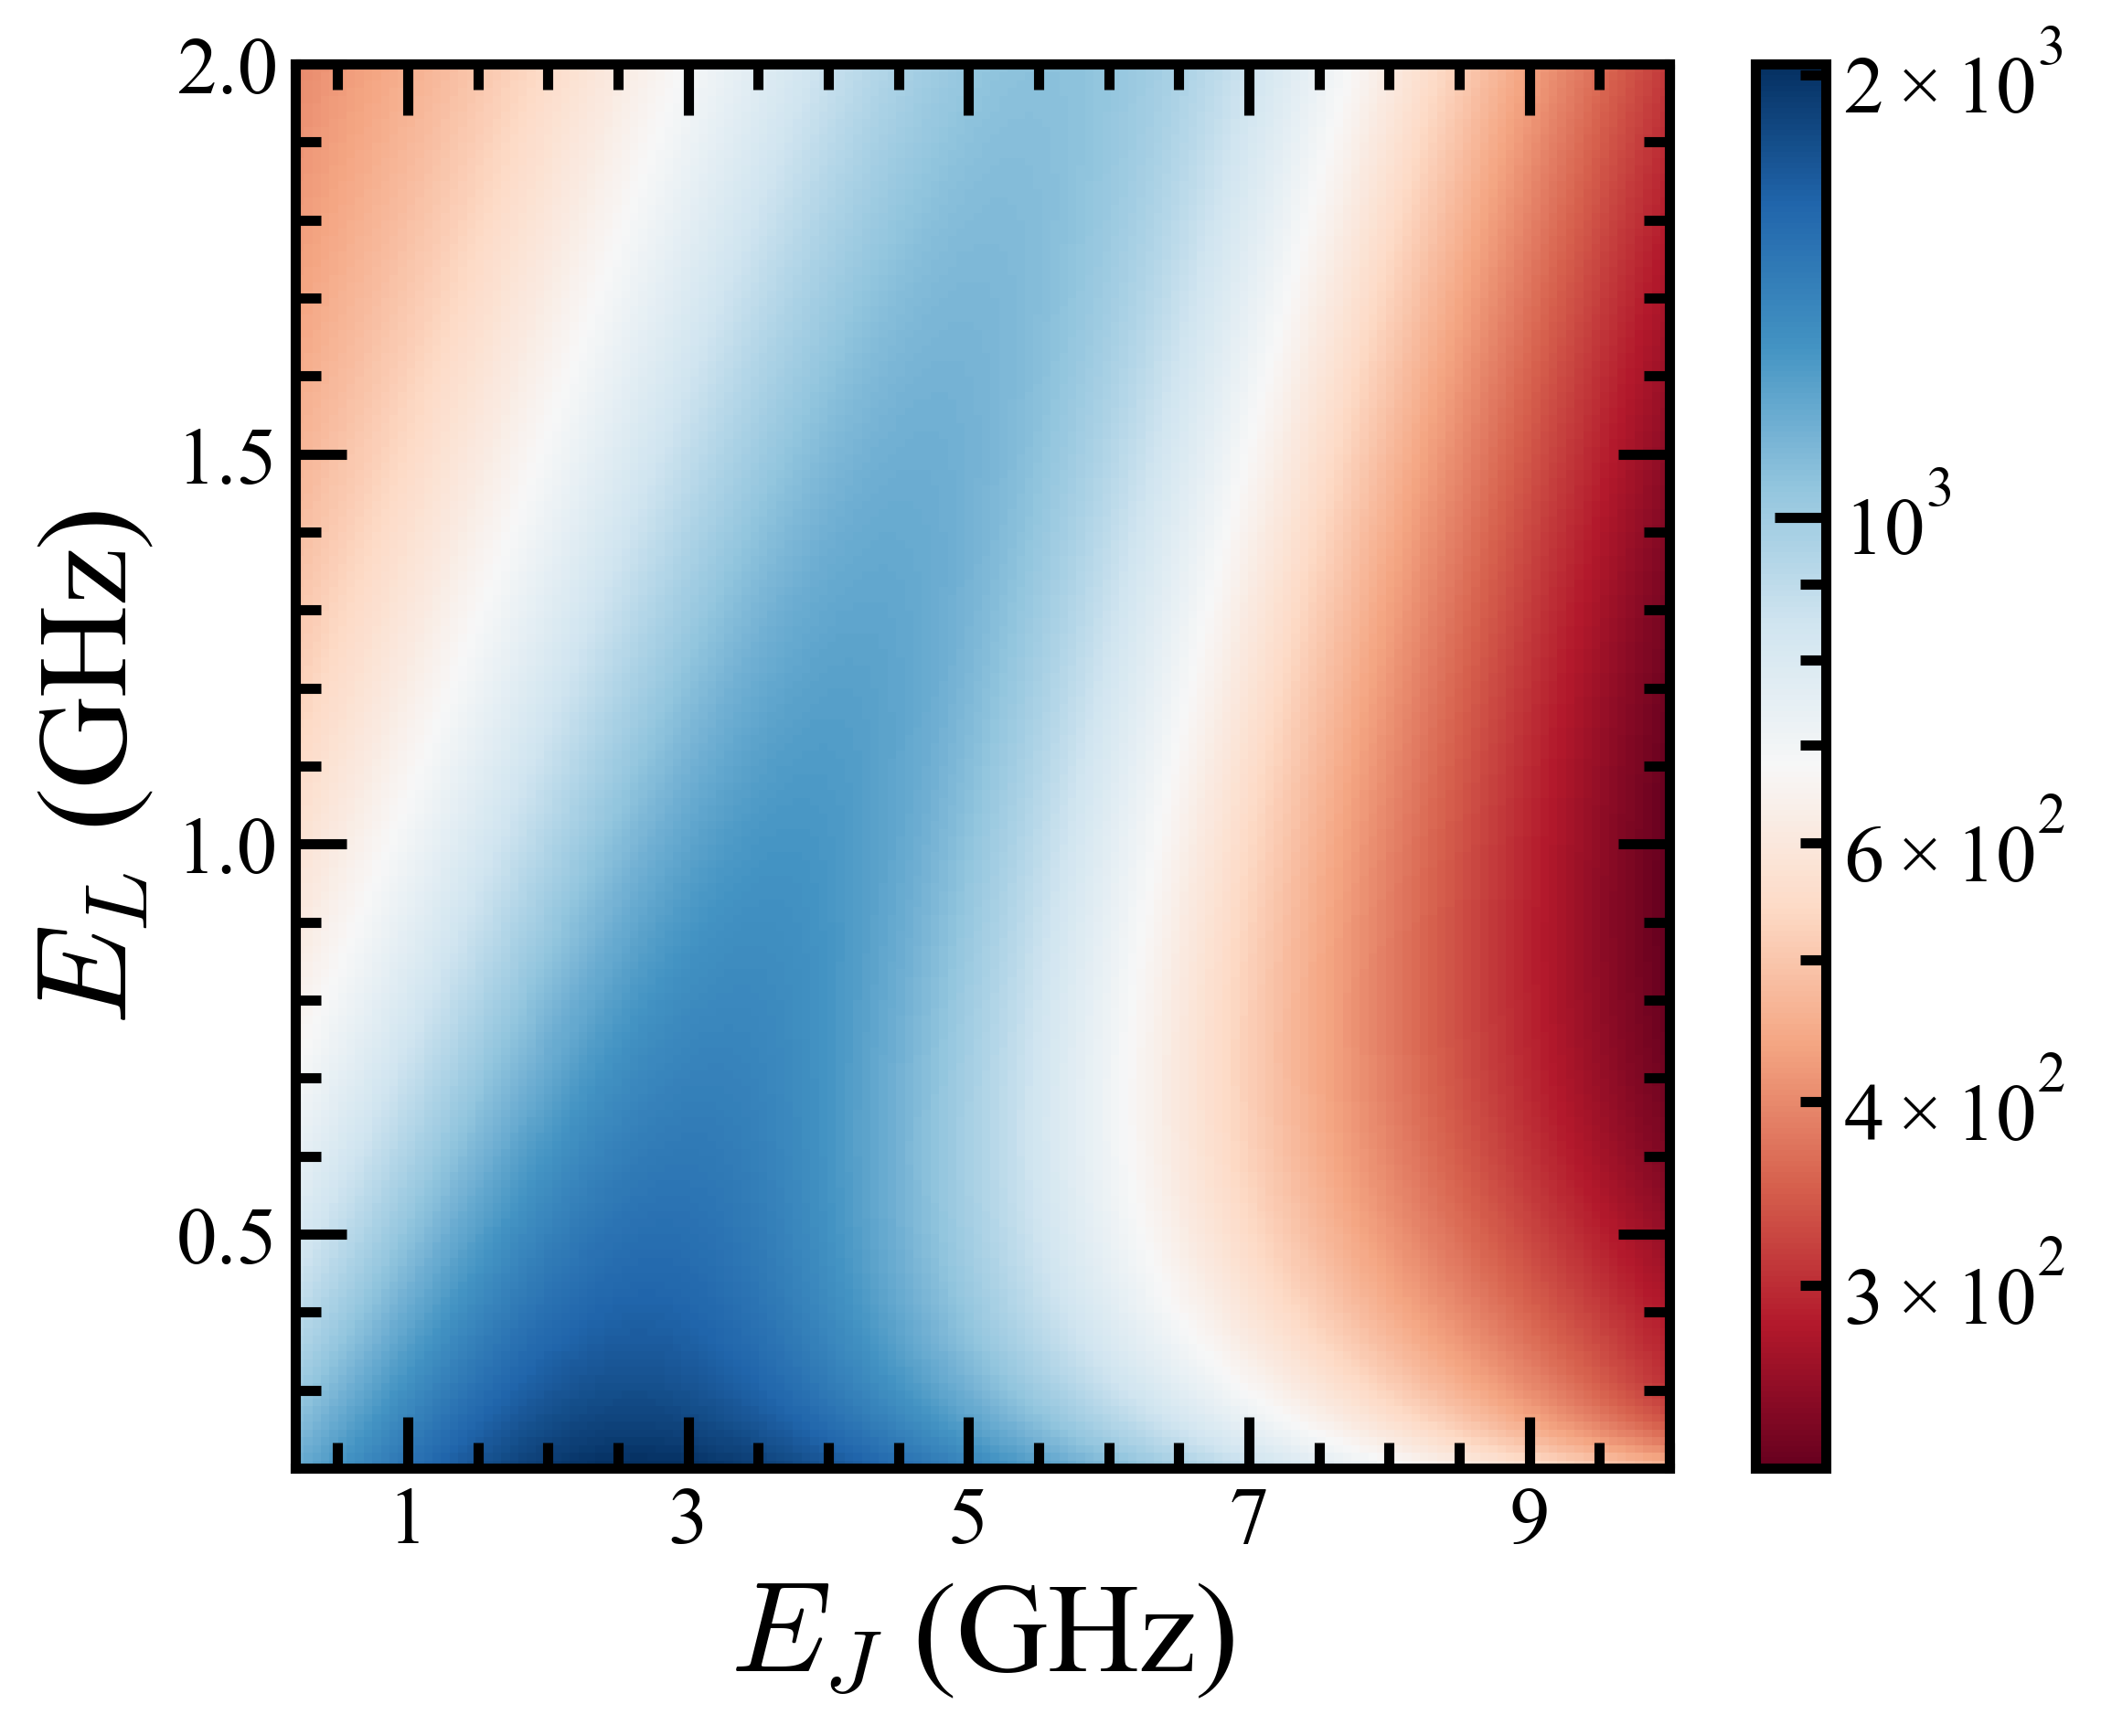

In [29]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'
figname = 'fluxonium_T1_sweep.pdf'

plt.figure(figsize=[6,5])

plt.ylabel(r'$E_L$ (GHz)')
plt.xlabel(r'$E_J$ (GHz)')
X,Y = np.meshgrid(E_J_array, E_L_array)
Z = (abs(gamma[:,:,1])+abs(gamma[:,:,0])).transpose()
plt.pcolormesh(X,Y,(Z**-1)*1e7, cmap = 'RdBu',norm=cl.LogNorm())
plt.yticks([0.5,1,1.5,2])
plt.xticks([1,3,5,7,9])
plt.colorbar()
plt.tight_layout()
plt.savefig(figpath+figname)

## Frequency fluctuation

In [2]:
N = 30 #number of levels
E_J = 4 #Josephson energy, GHz
E_C = 1 #Charging energy, GHz
E_L = 1 #Inductive energy, GHz
level_num = 10
phi_ext = 0.5 

H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi_ext*2*np.pi)
energies = H.eigenenergies()
anchor = energies[1] - energies[0]

In [5]:
dE_L = E_L*0.1
dE_J = E_J*0.1
#new EJ
E_J_fluc = np.linspace(E_J-dE_J, E_J+dE_J, 101)
E_L_fluc = np.linspace(E_L-dE_L, E_L+dE_L, 101)
trans_freq = np.zeros((len(E_J_fluc), len(E_L_fluc)))
for idx, E_J_temp in enumerate(E_J_fluc):
    for idy, E_L_temp in enumerate(E_L_fluc):
        H = fluxonium.bare_hamiltonian(N, E_L_temp, E_C, E_J_temp, phi_ext*2*np.pi)
        energies = H.eigenenergies()
        trans_freq[idx, idy] = energies[1] - energies[0] - anchor
        

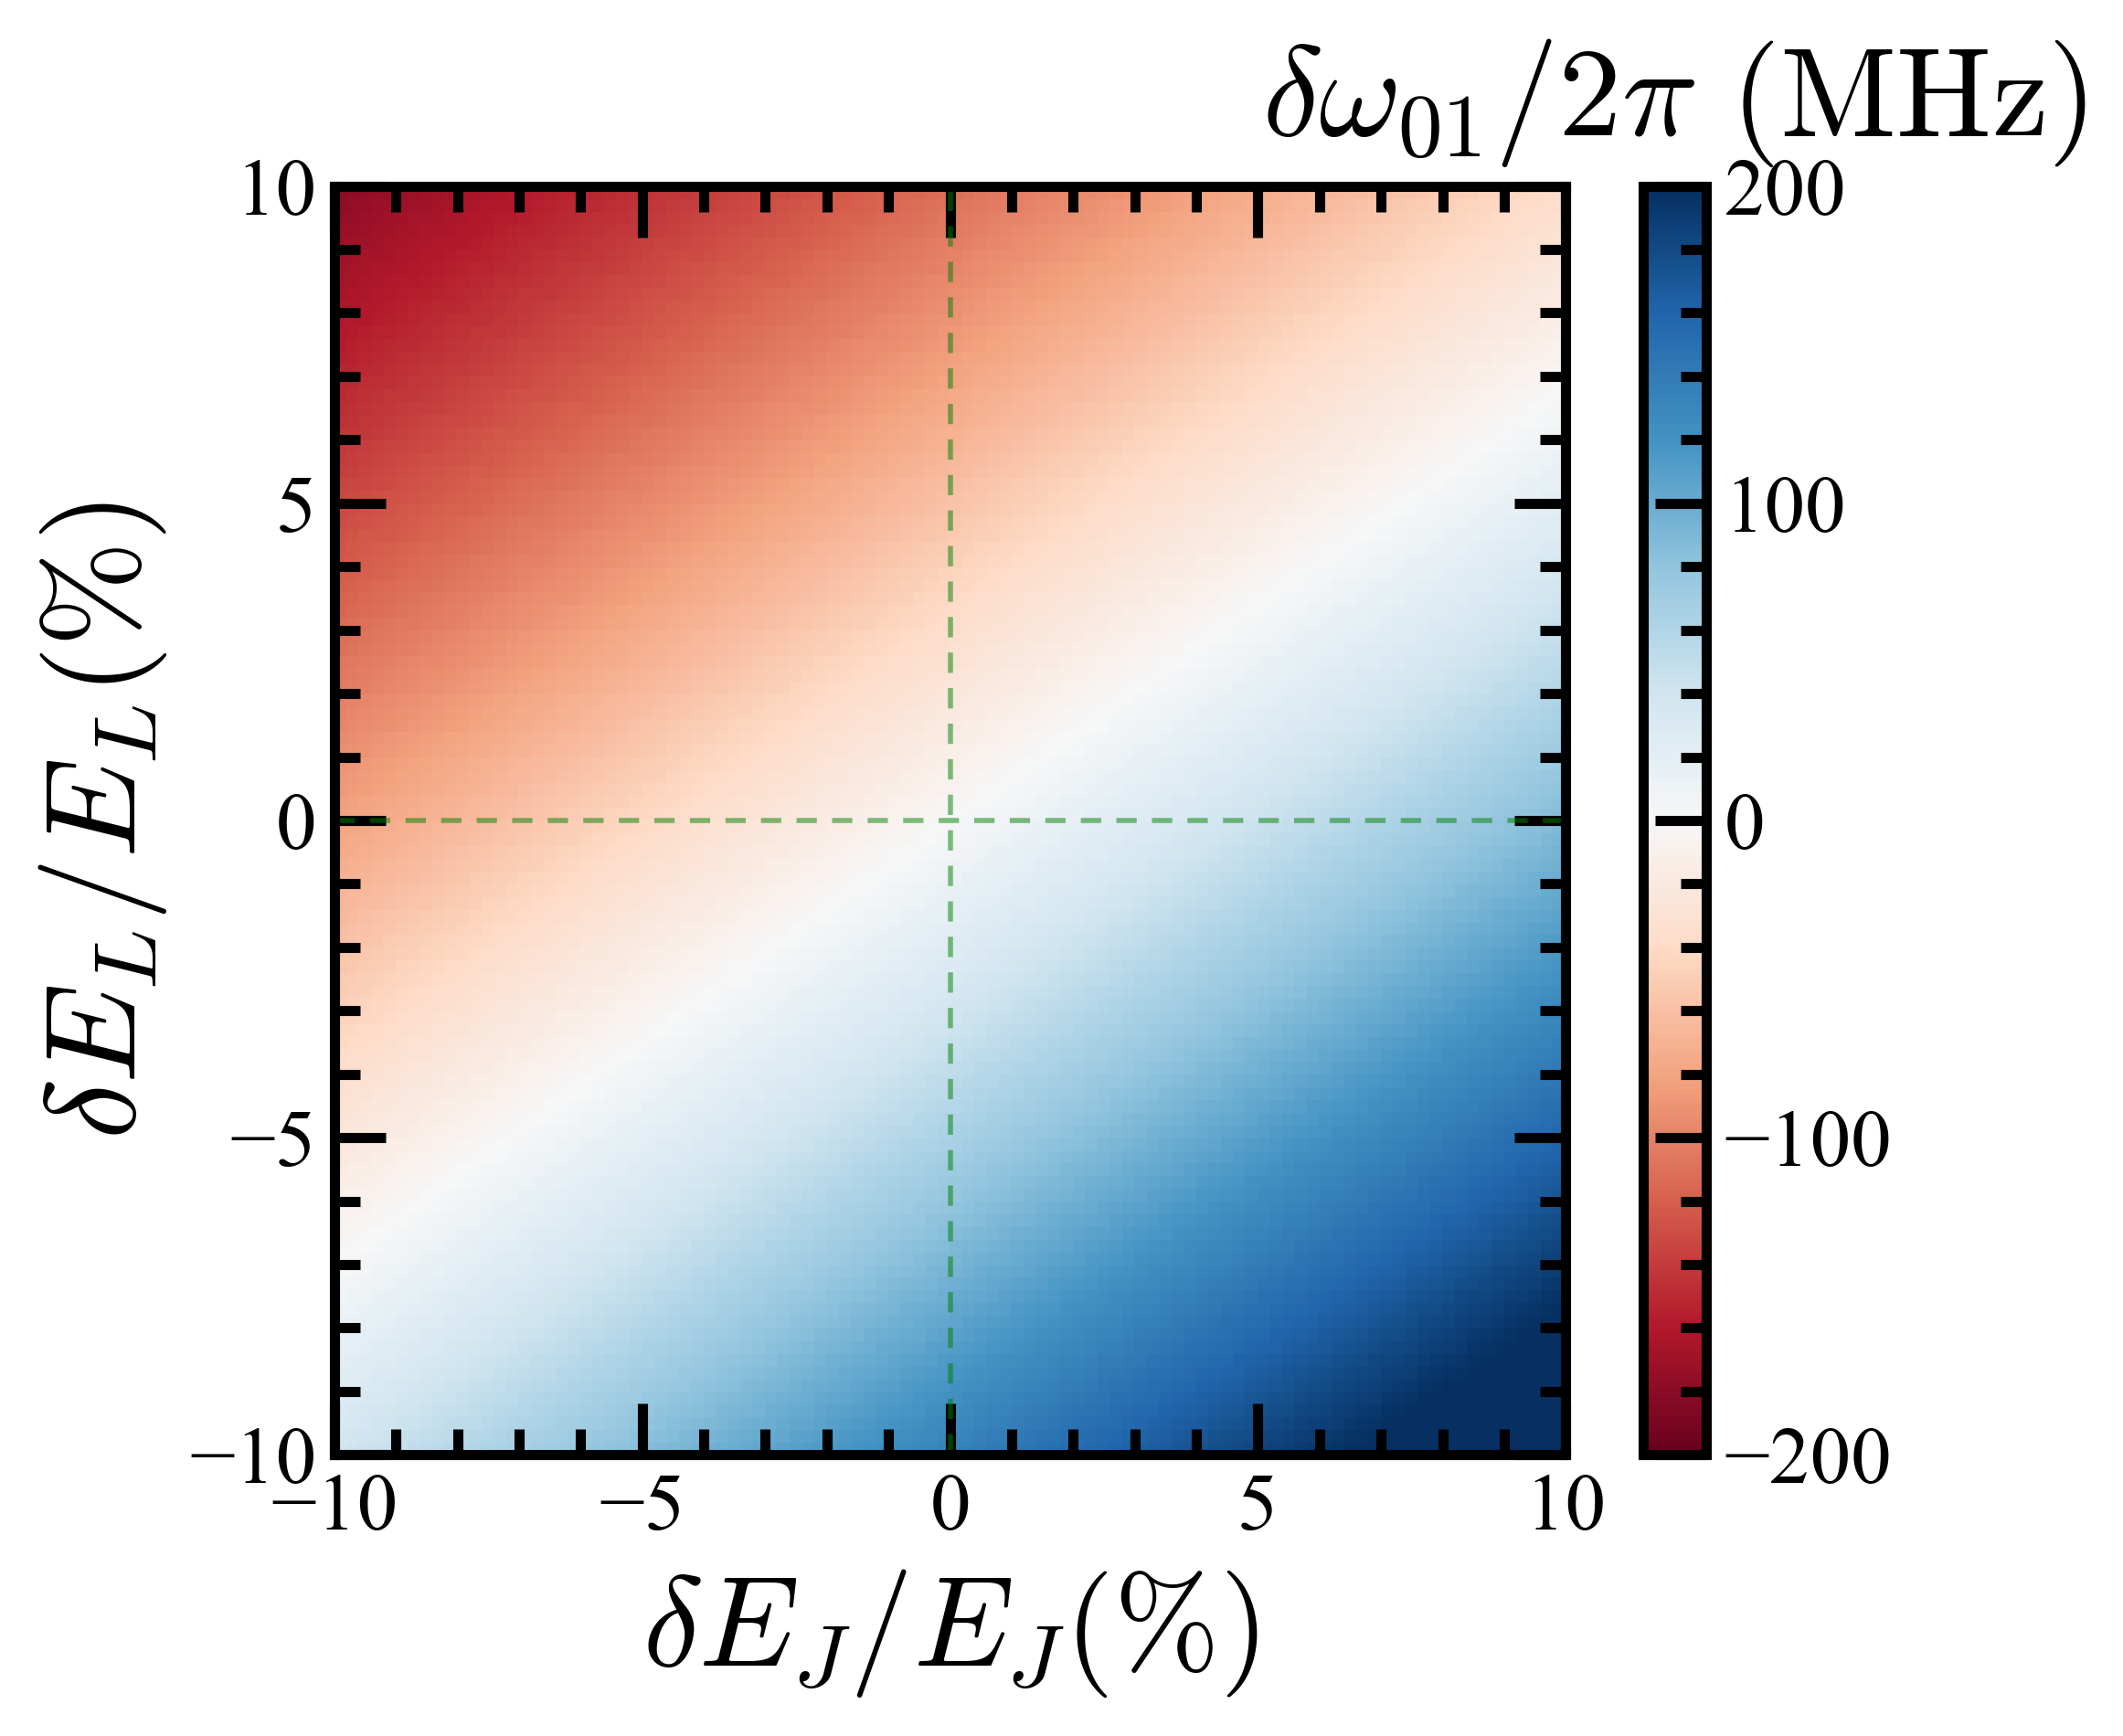

In [12]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'
figname = 'fluxonium_spectrum_sweep.pdf'


plt.figure(figsize = [6,5])
X,Y = np.meshgrid((E_J_fluc-E_J)/E_J*100, (E_L_fluc-E_L)/E_L*100)
Z = (trans_freq*1e3)
plt.pcolor(X, Y, Z, cmap = 'RdBu', vmax = 200, vmin = -200)
clb = plt.colorbar()
clb.ax.set_title(r'$\delta \omega_{01}/2\pi~(\mathrm{MHz})$')
plt.axhline(y=0, linestyle = '--', linewidth = 1.0, alpha = 0.5, color = 'g')
plt.axvline(x=0, linestyle = '--',linewidth = 1.0, alpha = 0.5, color = 'g')
plt.xlabel(r'$\delta E_J/E_J (\%)$')
plt.ylabel(r'$\delta E_L/E_L (\%)$')
plt.tight_layout()
plt.savefig(figpath+figname)

## Wavefunctions

In [12]:
N = 30 #number of levels
E_J = 3 #Josephson energy, GHz
E_C = 3 #Charging energy, GHz
E_L = 0.5 #Inductive energy, GHz
level_num = 10
phi_ext = np.linspace(0,1,101)
energies = np.zeros((len(phi_ext), level_num))
states = np.zeros((len(phi_ext), level_num, N))
max_display_y = 10

In [13]:
for idx, phi in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi)
    energies[idx, :] = H.eigenenergies()[:level_num]

In [14]:
def ho_wf(phi,l,Ec,El):
    ratio = (8.0*Ec/El)**(0.25)
    coeff = (2.0**l*np.math.factorial(l)*np.sqrt(np.pi)*ratio)**(-0.5)
    return coeff * np.exp(-0.5*(phi/ratio)**2) * hpoly(l,phi/ratio)

toPlotNum = 5
# phi_ext=[0.5]
phi = np.linspace(-3*np.pi,3*np.pi,101)
waveFunc = np.zeros((len(phi), len(phi_ext), toPlotNum))
potential = np.zeros((len(phi), len(phi_ext)))
for phi_idx, phi_e in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N,E_L,E_C,E_J, phi_e*2*np.pi)
    evalues, evectors = H.eigenstates()
    for state_idx in range(toPlotNum):
        wFunc = np.zeros(len(phi))
        for lvl_idx in range(N):
            coeff = np.real(evectors[state_idx].full()[lvl_idx, 0])
            wFunc = wFunc + coeff*ho_wf(phi, lvl_idx, E_C, E_L)
        waveFunc[:, phi_idx, state_idx] = wFunc + evalues[state_idx]
    potential[:,phi_idx] = 0.5*E_L*phi**2 - E_J*np.cos(phi-phi_e*2*np.pi) 

OSError: [Errno 63] File name too long: '/Users/longnguyen/Documents/wFunction1_[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13\n 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27\n 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41\n 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55\n 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69\n 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83\n 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97\n 0.98 0.99 1.  ].png'

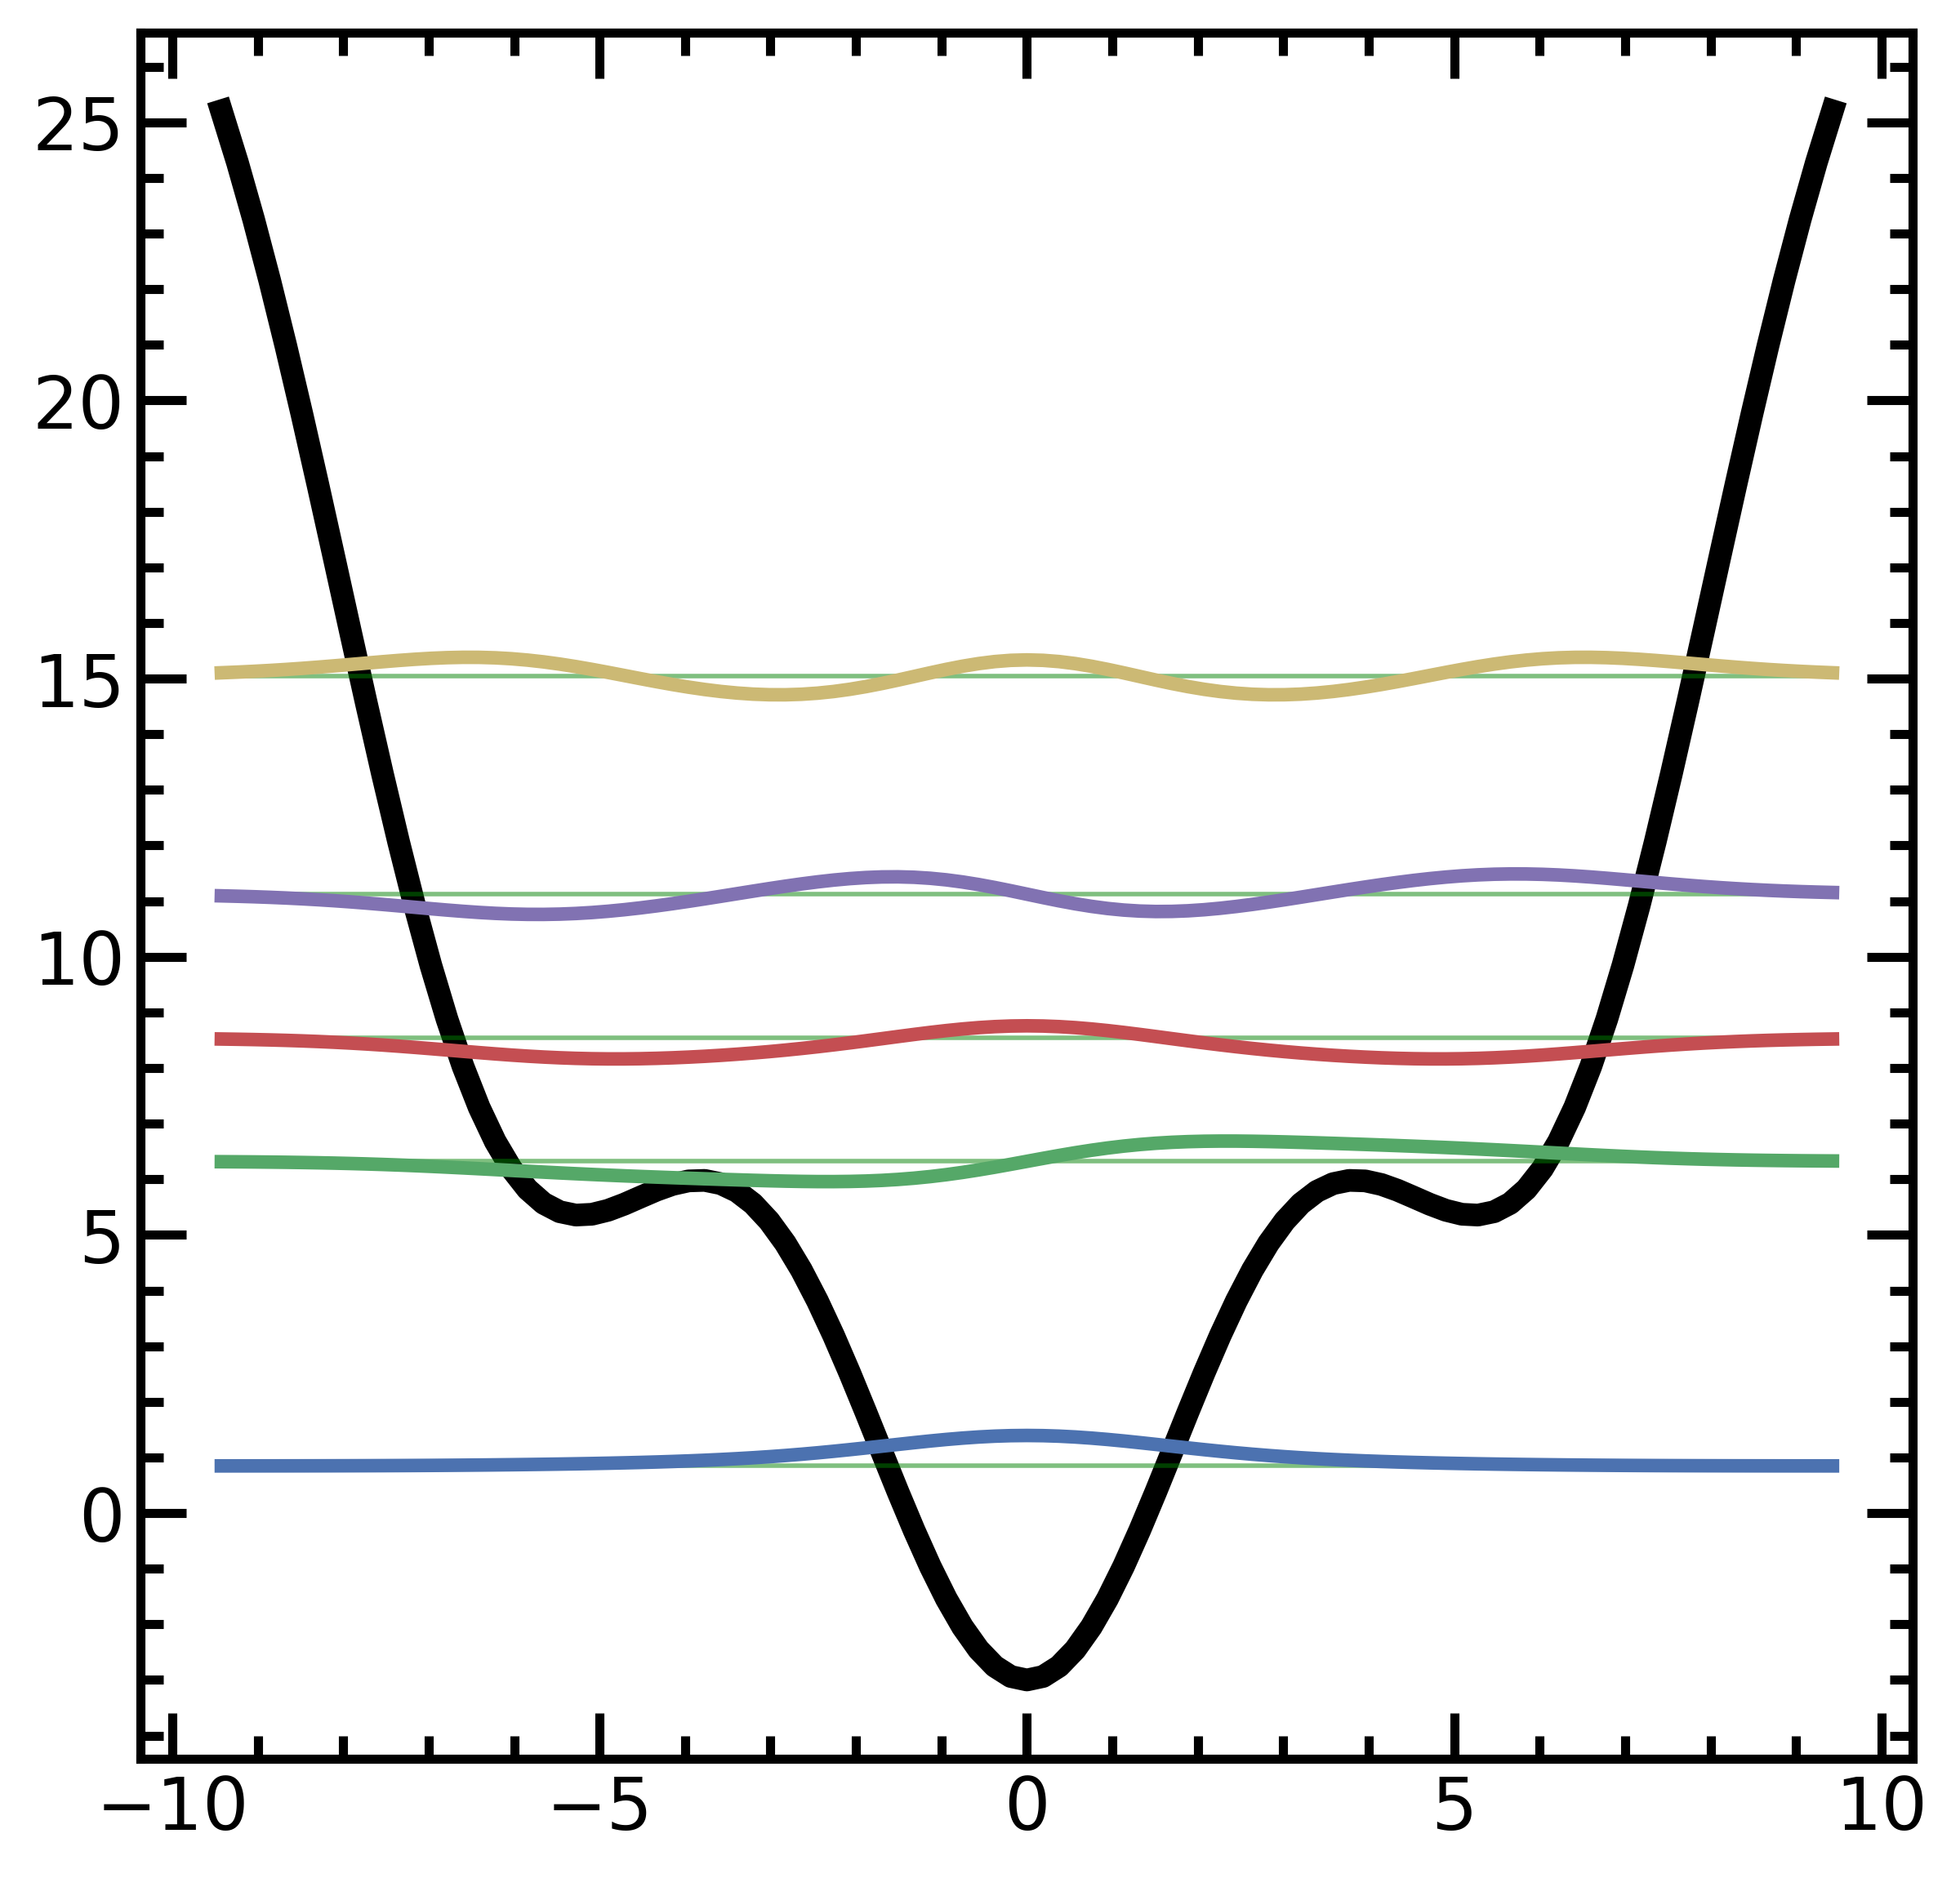

In [15]:
plt.figure(figsize = [7,7])  
path = "/Users/longnguyen/Documents/wFunction1_"
for phi_idx in range(len(phi_ext)):
    fname = path +str(phi_ext)+'.png'
    plt.plot(phi,potential[:, phi_idx], linewidth = 5, color = 'k')
    for state_idx in range(toPlotNum):
        plt.plot(phi,np.ones(len(phi))*energies[phi_idx,state_idx], linewidth = 1, alpha = 0.5, color = 'g')
        plt.plot(phi,waveFunc[:, phi_idx, state_idx])
    plt.savefig(fname)